<a href="https://colab.research.google.com/github/HabibBekir/Chest-X-Ray-Image-Classification/blob/main/Chest_X_Ray_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import required libraries
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random
import numpy as np
import shutil
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, VGG16, DenseNet121, MobileNetV2
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.utils import class_weight
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import hashlib
import itertools
import kagglehub
from tqdm import tqdm

# Chest X-Ray Classification using Deep Learning

This notebook implements a multi-class classification system for chest X-ray images to detect:
- Normal conditions
- Pneumonia
- Tuberculosis
- Covid-19

The implementation includes:
1. Dataset combination and preprocessing
2. Data augmentation and balancing
3. Model training using transfer learning
4. Model comparison and evaluation

#Functions

In [ ]:
# Helper functions for visualization and analysis
def plot_class_distribution(class_counts, title="Class Distribution"):
    plt.figure(figsize=(10, 6))
    bars = plt.bar(class_counts.keys(), class_counts.values())
    plt.title(title)
    plt.xlabel("Classes")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45)

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}',
                ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

In [ ]:
def create_model(base_model_class, model_name, input_shape=(224, 224, 3), num_classes=4):

    print(f"\nCreating {model_name} model...")

    # Create the base model with pre-trained weights
    base_model = base_model_class(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze the base model layers
    base_model.trainable = False

    # Create the model architecture
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)

    # Add global average pooling
    x = GlobalAveragePooling2D()(x)

    # Add dropout to prevent overfitting
    x = tf.keras.layers.Dropout(0.2)(x)

    # Add dense layers
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)

    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = tf.keras.Model(inputs, outputs)

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Print model summary
    print(f"\n{model_name} Summary:")
    model.summary()

    return model

In [ ]:
def plot_sample_images_grid(dataset_path, classes, samples_per_class=5, figsize=(15, 3)):
    """Plot a grid of sample images from each class"""
    fig, axes = plt.subplots(len(classes), samples_per_class, figsize=figsize)

    for i, cls in enumerate(classes):
        class_path = os.path.join(dataset_path, cls)
        image_files = random.sample(os.listdir(class_path), samples_per_class)

        for j, img_file in enumerate(image_files):
            img_path = os.path.join(class_path, img_file)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(f"{cls}", loc='left')

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_image_dimensions(dataset_path, classes):
    """Plot distribution of image dimensions"""
    widths = []
    heights = []

    for cls in classes:
        class_path = os.path.join(dataset_path, cls)
        for img_file in tqdm(os.listdir(class_path)[:100], desc=f"Analyzing {cls} images"):
            img_path = os.path.join(class_path, img_file)
            img = cv2.imread(img_path)
            heights.append(img.shape[0])
            widths.append(img.shape[1])

    plt.figure(figsize=(12, 4))

    plt.subplot(121)
    plt.hist(widths, bins=30)
    plt.title('Width Distribution')
    plt.xlabel('Width (pixels)')

    plt.subplot(122)
    plt.hist(heights, bins=30)
    plt.title('Height Distribution')
    plt.xlabel('Height (pixels)')

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_training_history(history, title="Model Training History"):
    """Plot training and validation metrics"""
    metrics = ['loss', 'accuracy']
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    for idx, metric in enumerate(metrics):
        axes[idx].plot(history.history[metric], label=f'Training {metric}')
        axes[idx].plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        axes[idx].set_title(f'Model {metric}')
        axes[idx].set_xlabel('Epoch')
        axes[idx].set_ylabel(metric)
        axes[idx].legend()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_models_comparison(histories, model_names):
    """Compare multiple models' performance"""
    metrics = ['accuracy', 'loss']
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    for metric_idx, metric in enumerate(metrics):
        for history, model_name in zip(histories, model_names):
            axes[metric_idx].plot(history.history[metric], label=f'{model_name} Training')
            axes[metric_idx].plot(history.history[f'val_{metric}'], label=f'{model_name} Validation')

        axes[metric_idx].set_title(f'Model {metric}')
        axes[metric_idx].set_xlabel('Epoch')
        axes[metric_idx].set_ylabel(metric)
        axes[metric_idx].legend()

    plt.suptitle('Model Comparison')
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_model_evaluation(model, test_generator, classes):
    """Comprehensive model evaluation plots"""
    # Get predictions
    y_pred = model.predict(test_generator, verbose=1)
    y_true = test_generator.classes
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=classes))

    # ROC Curves
    plt.figure(figsize=(10, 8))
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(y_true == i, y_pred[:, i])
        plt.plot(fpr, tpr, label=f'{classes[i]} (AUC = {auc(fpr, tpr):.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    plt.show()

#1. Dataset combination and preprocessing

In [ ]:
print("Downloading and combining datasets...")

In [ ]:
# Define paths to the three datasets on Kaggle
dataset_paths = {
    "first": "roshanmaur/imbalanced-tuberculosis-and-pnuemonia-dataset",
    "second": "sachinkumar413/covid-pneumonia-normal-chest-xray-images",
    "third": "paultimothymooney/chest-xray-pneumonia",
}

# Function to download datasets from Kaggle Hub
def download_dataset(dataset_name):
    try:
        dataset_path = kagglehub.dataset_download(dataset_name)
        return dataset_path
    except Exception as e:
        print(f"Error downloading {dataset_name}: {e}")
        return None

# Create a directory to store all downloaded datasets
download_dir = "downloaded_datasets"
os.makedirs(download_dir, exist_ok=True)

# Download all datasets into the download directory
paths = {name: download_dataset(path) for name, path in dataset_paths.items()}

# Define the final combined dataset path
combined_dataset_path = "combined_dataset"
os.makedirs(combined_dataset_path, exist_ok=True)

# Define class names
classes = ["Normal", "Pneumonia", "Tuberculosis", "Covid"]

100%|██████████| 5.87G/5.87G [01:15<00:00, 83.5MB/s]

Extracting files...


100%|██████████| 277M/277M [00:02<00:00, 111MB/s]

Extracting files...


100%|██████████| 2.29G/2.29G [00:23<00:00, 106MB/s] 

Extracting files...


In [ ]:
# Create class directories within the combined dataset path
for cls in classes:
    os.makedirs(os.path.join(combined_dataset_path, cls), exist_ok=True)

In [ ]:
# Function to copy files from source to destination, handling duplicates
def copy_files(source_dir, destination_dir):
    for filename in os.listdir(source_dir):
        source_path = os.path.join(source_dir, filename)
        destination_path = os.path.join(destination_dir, filename)

        if os.path.exists(destination_path):
            base, extension = os.path.splitext(filename)
            counter = 1
            while os.path.exists(destination_path):
                new_filename = f"{base}_{counter}{extension}"
                destination_path = os.path.join(destination_dir, new_filename)
                counter += 1
        shutil.copy2(source_path, destination_path)

In [ ]:
# Copy files from each dataset to the combined dataset directory ---

# Dataset 1: "imbalanced-tuberculosis-and-pnuemonia-dataset"
if paths["first"]:
    source_normal_path = os.path.join(paths["first"],"all_images", "Normal")
    source_pneumonia_path = os.path.join(paths["first"],"all_images", "Pneumonia")
    source_tuberculosis_path = os.path.join(paths["first"],"all_images", "Tuberculosis")

    if os.path.exists(source_normal_path):
        copy_files(source_normal_path, os.path.join(combined_dataset_path, "Normal"))
    if os.path.exists(source_pneumonia_path):
        copy_files(source_pneumonia_path, os.path.join(combined_dataset_path, "Pneumonia"))
    if os.path.exists(source_tuberculosis_path):
        copy_files(source_tuberculosis_path, os.path.join(combined_dataset_path, "Tuberculosis"))

# Dataset 2: "covid-pneumonia-normal-chest-xray-images"
if paths["second"]:
    source_normal_path = os.path.join(paths["second"], "NORMAL")
    source_pneumonia_path = os.path.join(paths["second"], "PNEUMONIA")
    source_covid_path = os.path.join(paths["second"], "COVID")

    if os.path.exists(source_normal_path):
        copy_files(source_normal_path, os.path.join(combined_dataset_path, "Normal"))
    if os.path.exists(source_pneumonia_path):
        copy_files(source_pneumonia_path, os.path.join(combined_dataset_path, "Pneumonia"))
    if os.path.exists(source_covid_path):
        copy_files(source_covid_path, os.path.join(combined_dataset_path, "Covid"))

# Dataset 3: "chest-xray-pneumonia"
if paths["third"]:
    for subset in ["train", "val", "test"]:
      source_normal_path = os.path.join(paths["third"],"chest_xray", subset, "NORMAL")
      source_pneumonia_path = os.path.join(paths["third"], "chest_xray", subset, "PNEUMONIA")

      if os.path.exists(source_normal_path):
          copy_files(source_normal_path, os.path.join(combined_dataset_path, "Normal"))
      if os.path.exists(source_pneumonia_path):
          copy_files(source_pneumonia_path, os.path.join(combined_dataset_path, "Pneumonia"))


print("Datasets combined successfully!")

Datasets combined successfully!


In [ ]:
print("\nRemoving duplicates...")


Removing duplicates...


In [ ]:
# Function to calculate SHA256 hash of a file
def calculate_sha256(filepath):
    hasher = hashlib.sha256()
    with open(filepath, 'rb') as f:
        while True:
            chunk = f.read(4096)  # Read file in chunks
            if not chunk:
                break
            hasher.update(chunk)
    return hasher.hexdigest()

# Function to find and remove duplicates based on SHA256 hash
def remove_duplicates(directory):
    hashes = {}
    duplicates = []

    for root, _, files in os.walk(directory):
        for filename in files:
            filepath = os.path.join(root, filename)
            file_hash = calculate_sha256(filepath)

            if file_hash in hashes:
                duplicates.append(filepath)
            else:
                hashes[file_hash] = filepath

    print(f"Found {len(duplicates)} duplicate images.")

    # Remove duplicates
    for filepath in duplicates:
        os.remove(filepath)
        print(f"Removed duplicate: {filepath}")

# Remove duplicates from the combined dataset
remove_duplicates(combined_dataset_path)

print("Duplicate removal complete!")

Streaming output truncated to the last 5000 lines.
Removed duplicate: combined_dataset/Normal/NORMAL-7605819-0001.jpeg
Removed duplicate: combined_dataset/Normal/NORMAL2-IM-1291-0001.jpeg
Removed duplicate: combined_dataset/Normal/NORMAL_1698.png
Removed duplicate: combined_dataset/Normal/NORMAL2-IM-1104-0001.jpeg
Removed duplicate: combined_dataset/Normal/IM-0497-0001-0001.jpeg
Removed duplicate: combined_dataset/Normal/NORMAL-5398062-0001.jpeg
Removed duplicate: combined_dataset/Normal/NORMAL-3861947-0001.jpeg
Removed duplicate: combined_dataset/Normal/NORMAL2-IM-0917-0001.jpeg
Removed duplicate: combined_dataset/Normal/NORMAL2-IM-1396-0001.jpeg
Removed duplicate: combined_dataset/Normal/NORMAL2-IM-1161-0001.jpeg
Removed duplicate: combined_dataset/Normal/NORMAL-284113-0003.jpeg
Removed duplicate: combined_dataset/Normal/NORMAL-9799657-0001.jpeg
Removed duplicate: combined_dataset/Normal/IM-0023-0001.jpeg
Removed duplicate: combined_dataset/Normal/NORMAL-3486729-0001.jpeg
Removed dup

#2. Data augmentation and balancing

In [ ]:
print("\nBalancing dataset...")


Balancing dataset...


In [ ]:
# Define the target image count for each class after balancing
target_image_count = 2000

# Data augmentation settings
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Function to augment images and save them
def augment_images(class_path, target_count):
    images = os.listdir(class_path)
    current_count = len(images)
    num_images_to_augment = target_count - current_count

    if num_images_to_augment > 0:
        print(f"Augmenting {class_path} with {num_images_to_augment} images...")
        i = 0
        for batch in datagen.flow_from_directory(
            directory=os.path.dirname(class_path), # Parent directory of the class
            classes=[os.path.basename(class_path)], # List with the name of the class
            target_size=(224, 224),
            batch_size=1,
            save_to_dir=class_path,
            save_prefix="aug",
            save_format="jpg",
            shuffle=True
        ):
            i += 1
            if i >= num_images_to_augment:
                break  # Stop creating images once we reach the target
    else:
        print(f"{class_path} already has enough images. No augmentation needed")

# Function to downsample images
def downsample_images(class_path, target_count):
    images = os.listdir(class_path)
    current_count = len(images)
    num_images_to_delete = current_count - target_count

    if num_images_to_delete > 0:
        print(f"Downsampling {class_path} by removing {num_images_to_delete} images...")
        images_to_delete = random.sample(images, num_images_to_delete)
        for img in images_to_delete:
            os.remove(os.path.join(class_path, img))
    else:
        print(f"{class_path} already has few enough images. No downsampling needed")

# --- Balance the dataset ---
for cls in classes:
    class_path = os.path.join(combined_dataset_path, cls)
    current_count = len(os.listdir(class_path))

    if current_count < target_image_count:
        augment_images(class_path, target_image_count)
    elif current_count > target_image_count:
        downsample_images(class_path, target_image_count)

print("Dataset balancing complete!")

Downsampling combined_dataset/Normal by removing 8942 images...
Downsampling combined_dataset/Pneumonia by removing 4036 images...
Augmenting combined_dataset/Tuberculosis with 212 images...
Found 1788 images belonging to 1 classes.
Augmenting combined_dataset/Covid with 463 images...
Found 1537 images belonging to 1 classes.
Dataset balancing complete!


In [ ]:
print("\nSplitting dataset into train/val/test sets...")


Splitting dataset into train/val/test sets...


In [ ]:
# Define split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Create directories for train, val, and test
train_dir = os.path.join(combined_dataset_path, 'train')
val_dir = os.path.join(combined_dataset_path, 'val')
test_dir = os.path.join(combined_dataset_path, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Function to move files to corresponding directories
def move_files(image_paths, destination_folder):
    os.makedirs(destination_folder, exist_ok=True)  # Create folder if it doesn't exist
    for img_path in image_paths:
        img_name = os.path.basename(img_path)  # Get image filename
        shutil.move(img_path, os.path.join(destination_folder, img_name))  # Move file

# Manually split data for each class
for cls in classes:
    class_path = os.path.join(combined_dataset_path, cls)
    images = os.listdir(class_path)

    # Shuffle the images to ensure randomness
    random.shuffle(images)

    # Calculate the number of images for each split
    total_images = len(images)
    train_count = int(train_ratio * total_images)
    val_count = int(val_ratio * total_images)
    test_count = total_images - train_count - val_count

    # Split the images
    train_images = images[:train_count]
    val_images = images[train_count:train_count + val_count]
    test_images = images[train_count + val_count:]

    # Move files to corresponding directories
    move_files([os.path.join(class_path, img) for img in train_images], os.path.join(train_dir, cls))
    move_files([os.path.join(class_path, img) for img in val_images], os.path.join(val_dir, cls))
    move_files([os.path.join(class_path, img) for img in test_images], os.path.join(test_dir, cls))

print("Dataset has been successfully split into train, validation, and test sets.")

Dataset has been successfully split into train, validation, and test sets.


#3. Model training using transfer learning

In [ ]:
# Define image size and batch size
img_size = (224, 224)
batch_size = 32

# Create image data generators for training, validation, and testing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Define the paths for training, validation, and testing sets (adjust as needed)
train_dir = os.path.join(combined_dataset_path, 'train')
validation_dir = os.path.join(combined_dataset_path, 'val')
test_dir = os.path.join(combined_dataset_path, 'test')


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False # Important for proper evaluation
)

Found 5600 images belonging to 4 classes.
Found 1200 images belonging to 4 classes.
Found 1200 images belonging to 4 classes.


In [ ]:
# Define callbacks for training
callbacks = [
    ModelCheckpoint(
        'best_model_{epoch:02d}.h5',
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

MobileNetV2

In [ ]:
# Train MobileNetV2
print("\nTraining MobileNetV2...")
mobilenet_model = create_model(MobileNetV2, "MobileNetV2")
history_mobilenet = mobilenet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)


Training MobileNetV2...

Creating MobileNetV2 model...

MobileNetV2 Summary:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1024)                │       1,311,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,096,580 (15.63 MB)

 Trainable params: 1,838,596 (7.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 765ms/step - accuracy: 0.5991 - loss: 10.5677
Epoch 1: val_accuracy improved from -inf to 0.71000, saving model to best_model_01.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 159s 859ms/step - accuracy: 0.5996 - loss: 10.5424 - val_accuracy: 0.7100 - val_loss: 2.1223 - learning_rate: 0.0010
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - accuracy: 0.7693 - loss: 1.6314
Epoch 2: val_accuracy improved from 0.71000 to 0.79667, saving model to best_model_02.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 119s 682ms/step - accuracy: 0.7693 - loss: 1.6301 - val_accuracy: 0.7967 - val_loss: 0.9814 - learning_rate: 0.0010
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 618ms/step - accuracy: 0.7944 - loss: 0.9543
Epoch 3: val_accuracy did not improve from 0.79667
175/175 ━━━━━━━━━━━━━━━━━━━━ 119s 682ms/step - accuracy: 0.7944 - loss: 0.9539 - val_accuracy: 0.7367 - val_loss: 0.9168 - learning_rate: 0.0010
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.7880 - loss: 0.7960
Epoch 4: val_accuracy improved from 0.79667 to 0.84250, saving model to best_model_04.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 118s 674ms/step - accuracy: 0.7880 - loss: 0.7959 - val_accuracy: 0.8425 - val_loss: 0.6511 - learning_rate: 0.0010
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 600ms/step - accuracy: 0.7983 - loss: 0.7362
Epoch 5: val_accuracy did not improve from 0.84250
175/175 ━━━━━━━━━━━━━━━━━━━━ 116s 663ms/step - accuracy: 0.7983 - loss: 0.7362 - val_accuracy: 0.7800 - val_loss: 0.7120 - learning_rate: 0.0010
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - accuracy: 0.8002 - loss: 0.7140
Epoch 6: val_accuracy did not improve from 0.84250
175/175 ━━━━━━━━━━━━━━━━━━━━ 120s 685ms/step - accuracy: 0.8003 - loss: 0.7139 - val_accuracy: 0.8308 - val_loss: 0.6400 - learning_rate: 0.0010
Epoch 7/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - accuracy: 0.7936 - loss: 0.7060
Epoch 7: val_accuracy improved from 0.84250 to 0.86583, saving model to best_model_07.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 119s 679ms/step - accuracy: 0.7936 - loss: 0.7060 - val_accuracy: 0.8658 - val_loss: 0.5653 - learning_rate: 0.0010
Epoch 8/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 629ms/step - accuracy: 0.8111 - loss: 0.6682
Epoch 8: val_accuracy did not improve from 0.86583
175/175 ━━━━━━━━━━━━━━━━━━━━ 121s 694ms/step - accuracy: 0.8111 - loss: 0.6683 - val_accuracy: 0.8275 - val_loss: 0.6581 - learning_rate: 0.0010
Epoch 9/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - accuracy: 0.7960 - loss: 0.6881
Epoch 9: val_accuracy did not improve from 0.86583
175/175 ━━━━━━━━━━━━━━━━━━━━ 117s 669ms/step - accuracy: 0.7961 - loss: 0.6880 - val_accuracy: 0.8433 - val_loss: 0.5920 - learning_rate: 0.0010
Epoch 10/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 615ms/step - accuracy: 0.8205 - loss: 0.6535
Epoch 10: val_accuracy did not improve from 0.86583

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
175/175 ━━━━━━━━━━━━━━━━━━━━ 119s 682ms/step - accuracy: 0.8204 - l

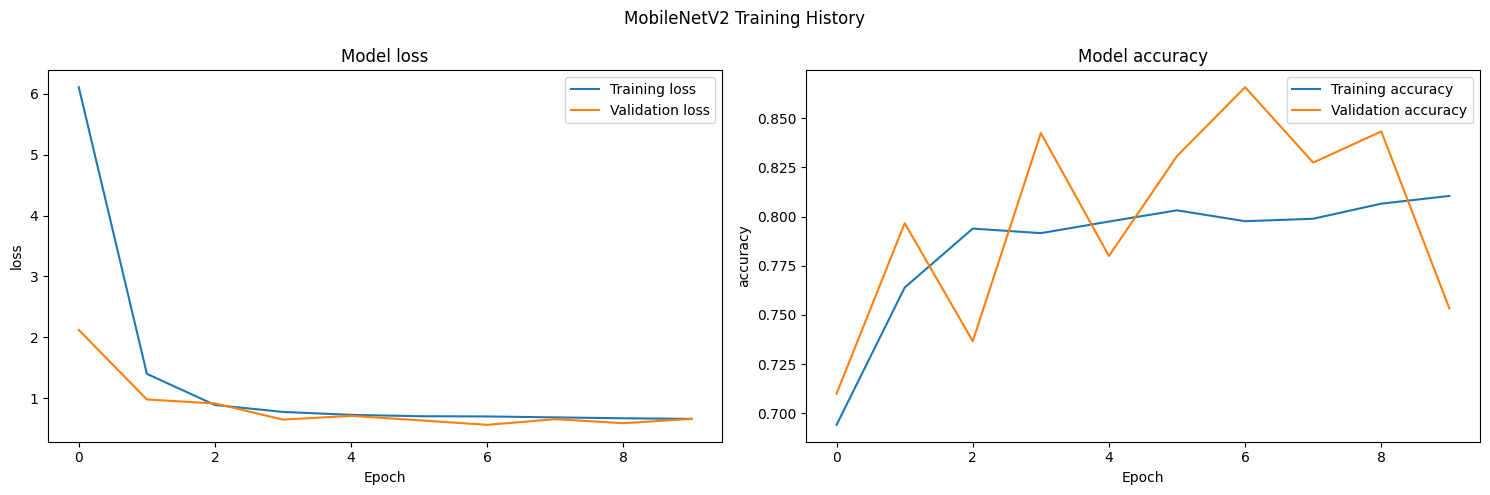

38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step


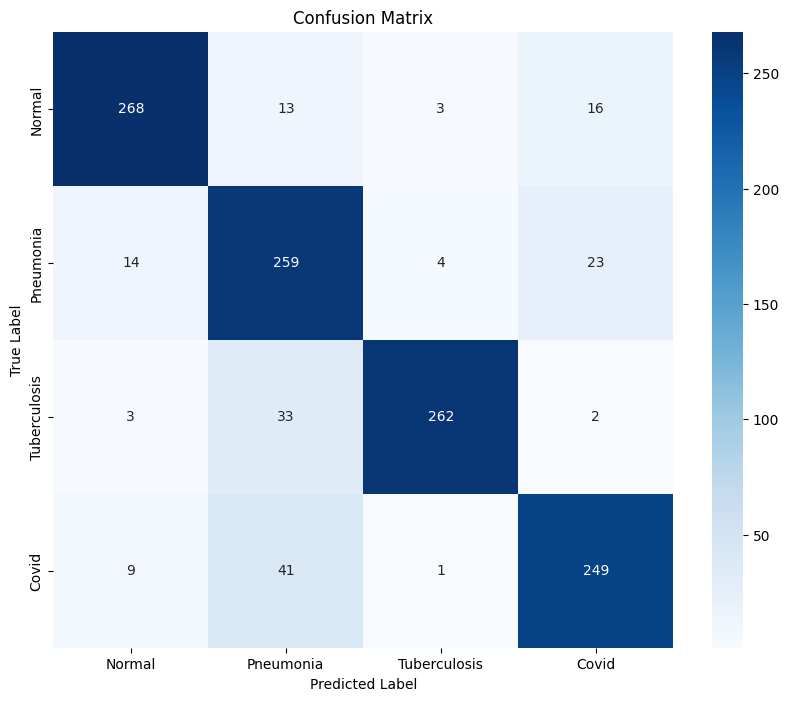


Classification Report:
              precision    recall  f1-score   support

      Normal       0.91      0.89      0.90       300
   Pneumonia       0.75      0.86      0.80       300
Tuberculosis       0.97      0.87      0.92       300
       Covid       0.86      0.83      0.84       300

    accuracy                           0.86      1200
   macro avg       0.87      0.86      0.87      1200
weighted avg       0.87      0.86      0.87      1200



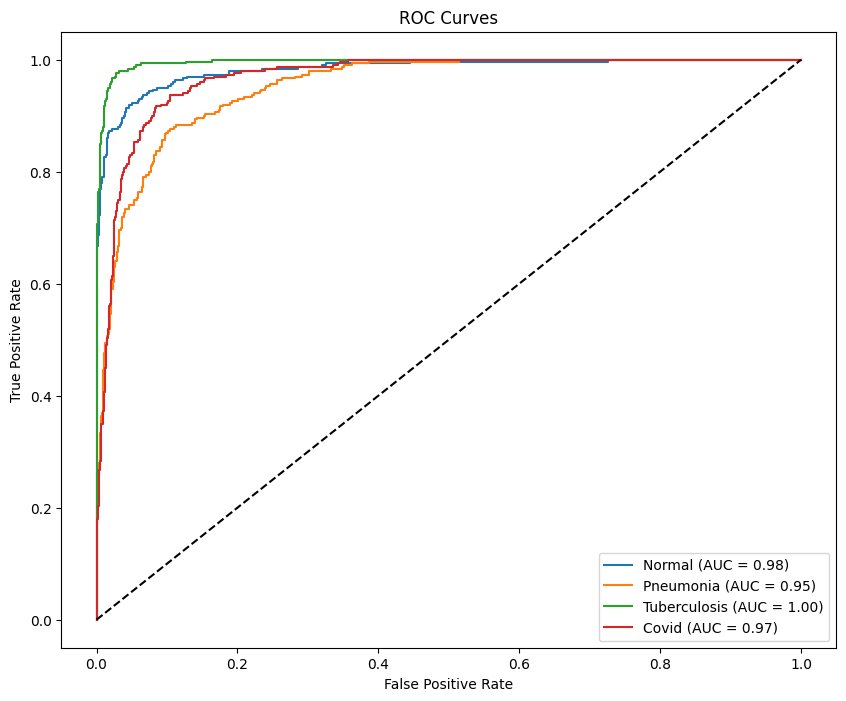

In [ ]:
plot_training_history(history_mobilenet, "MobileNetV2 Training History")
plot_model_evaluation(mobilenet_model, test_generator, classes)

VGG16

In [ ]:
# Train VGG16
print("\nTraining VGG16...")
vgg_model = create_model(VGG16, "VGG16")
history_vgg = vgg_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)


Training VGG16...

Creating VGG16 model...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

VGG16 Summary:


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,766,852 (60.15 MB)

 Trainable params: 1,052,164 (4.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.4106 - loss: 6.7385
Epoch 1: val_accuracy did not improve from 0.86583
175/175 ━━━━━━━━━━━━━━━━━━━━ 146s 759ms/step - accuracy: 0.4110 - loss: 6.7213 - val_accuracy: 0.6408 - val_loss: 1.3317 - learning_rate: 0.0010
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - accuracy: 0.5509 - loss: 1.4049
Epoch 2: val_accuracy did not improve from 0.86583
175/175 ━━━━━━━━━━━━━━━━━━━━ 127s 729ms/step - accuracy: 0.5510 - loss: 1.4044 - val_accuracy: 0.6708 - val_loss: 1.0288 - learning_rate: 0.0010
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 651ms/step - accuracy: 0.5802 - loss: 1.1860
Epoch 3: val_accuracy did not improve from 0.86583
175/175 ━━━━━━━━━━━━━━━━━━━━ 127s 722ms/step - accuracy: 0.5803 - loss: 1.1859 - val_accuracy: 0.6367 - val_loss: 0.9939 - learning_rate: 0.0010
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - accuracy: 0.5955 - loss: 1.0983
Epoch 4: val_accuracy did not improve from 0.86583
175/175 ━

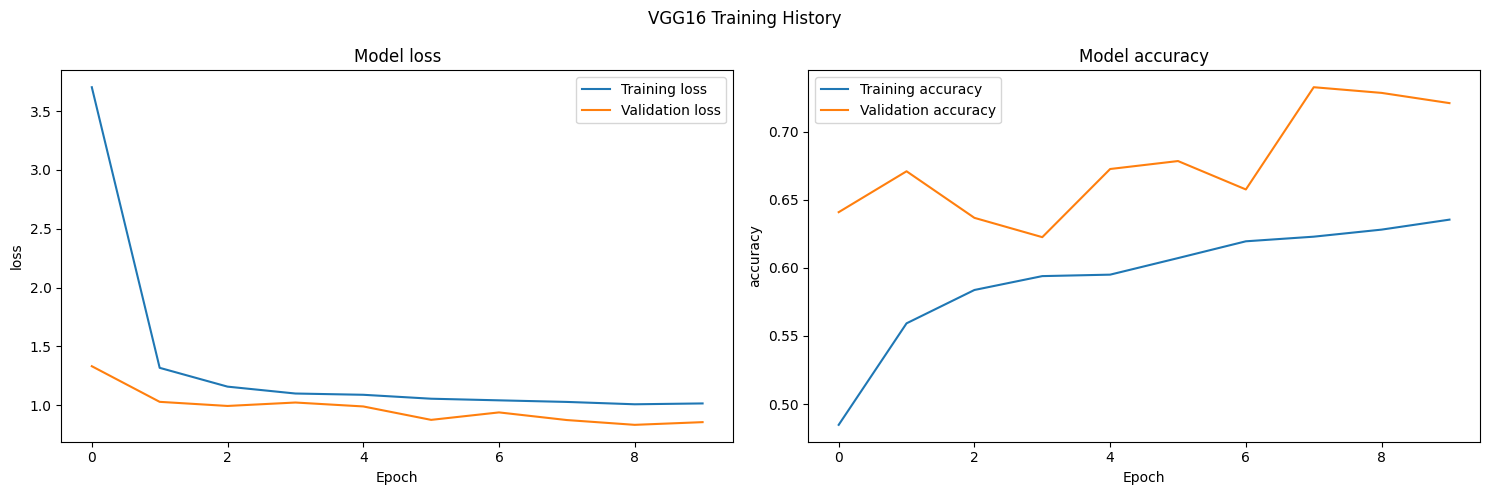

38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 330ms/step


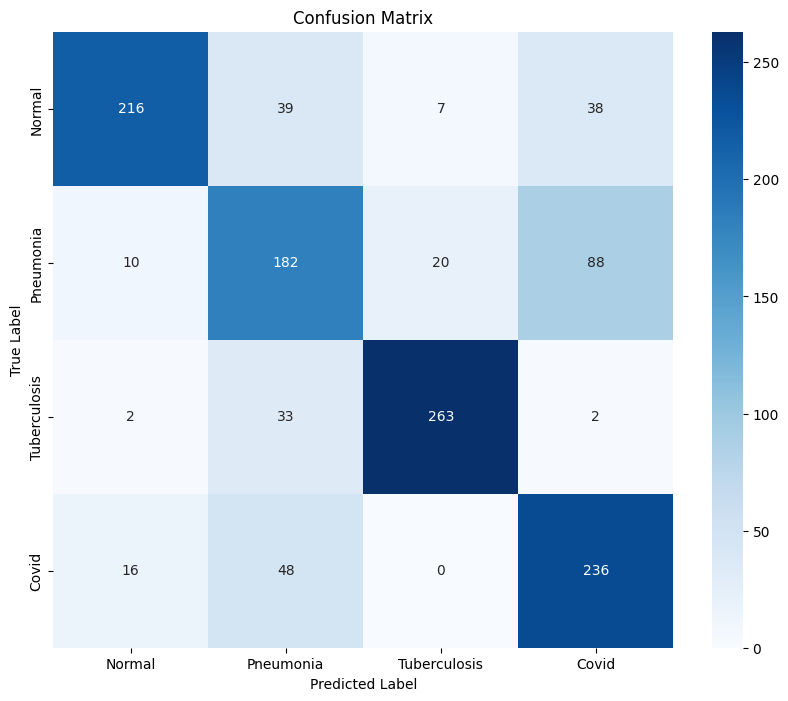


Classification Report:
              precision    recall  f1-score   support

      Normal       0.89      0.72      0.79       300
   Pneumonia       0.60      0.61      0.60       300
Tuberculosis       0.91      0.88      0.89       300
       Covid       0.65      0.79      0.71       300

    accuracy                           0.75      1200
   macro avg       0.76      0.75      0.75      1200
weighted avg       0.76      0.75      0.75      1200



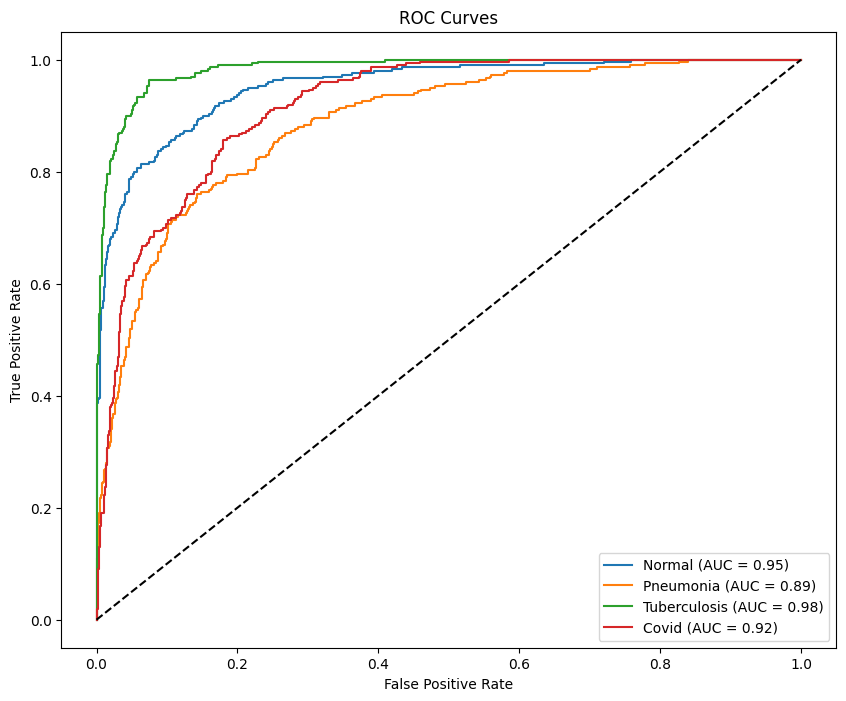

In [ ]:
plot_training_history(history_vgg, "VGG16 Training History")
plot_model_evaluation(vgg_model, test_generator, classes)

Stacking Model

In [ ]:
print("\nTraining ResNet50...")
resnet_model = create_model(ResNet50, "ResNet50")
history_resnet = resnet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)

In [ ]:
plot_training_history(history_resnet, "resnet50 Training History")
plot_model_evaluation(resnet_model, test_generator, classes)

In [ ]:
print("\nTraining DenseNet121...")
densenet_model = create_model(DenseNet121, "DenseNet121")
history_densenet = densenet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)

In [ ]:
plot_training_history(history_densenet, "DenseNet121 Training History")
plot_model_evaluation(densenet_model, test_generator, classes)

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
def create_stacking_model(base_models, final_estimator):

    # Extract predictions from base models
    X_train_stacking = np.hstack([model.predict(train_generator) for model in base_models])
    X_test_stacking = np.hstack([model.predict(test_generator) for model in base_models])

    # Train the final estimator on the predictions of the base models
    stacking_model = final_estimator
    history_stacking=stacking_model.fit(X_train_stacking, train_generator.classes)

    # Make predictions using the stacking model
    predictions = stacking_model.predict(X_test_stacking)
    return history_stacking, stacking_model, predictions

history_stacking, stacking_model, predictions = create_stacking_model([resnet_model, densenet_model], LogisticRegression())


In [ ]:
plot_training_history(history_stacking, "stacking Training History")
plot_model_evaluation(stacking_model, test_generator, classes)

#4. Model comparison and evaluation


Comparing all models...


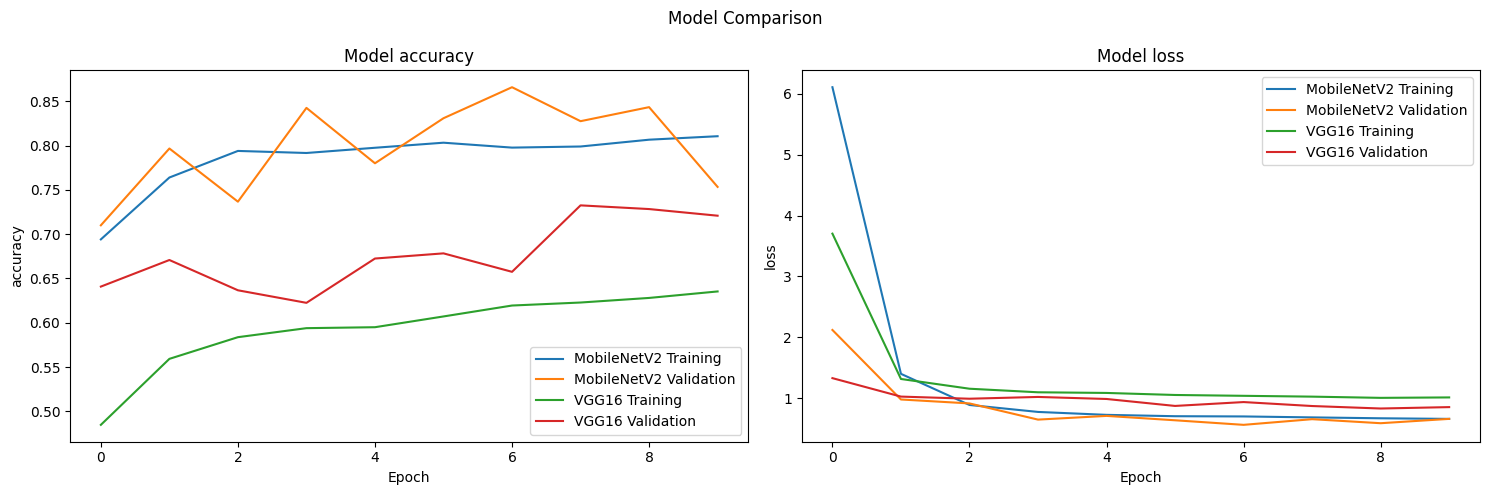

In [ ]:
# Compare all models
print("\nComparing all models...")
histories = [history_mobilenet, history_vgg]
model_names = ['MobileNetV2', 'VGG16']
plot_models_comparison(histories, model_names)

In [ ]:
# Save final results and models
results = {
    'mobilenet': {
        'history': history_mobilenet.history,
        'final_metrics': mobilenet_model.evaluate(test_generator, verbose=0)
    },
    'vgg': {
        'history': history_vgg.history,
        'final_metrics': vgg_model.evaluate(test_generator, verbose=0)
    }
}

In [ ]:
print("\nFinal Results:")
for model_name, model_results in results.items():
    print(f"\n{model_name.upper()} Final Metrics:")
    print(f"Test Loss: {model_results['final_metrics'][0]:.4f}")
    print(f"Test accuracy: {model_results['final_metrics'][1]:.4f}")


Final Results:

MOBILENET Final Metrics:
Test Loss: 0.5689
Test accuracy: 0.8650

VGG Final Metrics:
Test Loss: 0.8462
Test accuracy: 0.7475
